In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Loading in data

In [2]:
def getNumFromOneHot(inp):
    for i in range(10):
        if inp[i] == 1:
            return i

In [3]:
def draw_stroke_sequence(sequence, save_path=None, show=True):
    """
    sequence: numpy array or list of shape (T, 4) where each row is [dx, dy, eos, eod]
    save_path: optional path to save the plot as an image
    show: whether to display the plot
    """
    x, y = 0, 0
    xs, ys = [], []

    for dx, dy, eos, eod in sequence:
        x += dx*28
        y += dy*28
        xs.append(x)
        ys.append(y)

        if eos > 0.5:  # end of stroke
            xs.append(None)
            ys.append(None)

        if eod > 0.5:
            break

    plt.figure(figsize=(2, 2))
    plt.plot(xs, ys, linewidth=2)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.axis('equal')
    
    plt.show()

In [27]:
datas = [[] for _ in range(10)]

for i in range(10000):
    try:
        data = np.loadtxt(f'../sequences/testimg-{i}-targetdata.txt', delimiter=' ')
    except FileNotFoundError:
        print(f"❌ File not found at path: {i}")
        continue
    
    inputOneshot = data[0, 0:10]
    outputStrokes = data[:, 10:]
    outputStrokes[:, 0] = outputStrokes[:, 0]/28
    outputStrokes[:, 1] = outputStrokes[:, 1]/28
    
    datas[getNumFromOneHot(inputOneshot)].append(outputStrokes)

In [28]:
temp_input_data = []
temp_output_data = []

for i in range(10):
    temp_onehot = np.zeros(10)
    temp_onehot[i] = 1
    
    smallest_10 = sorted(datas[i], key=lambda x: len(x[1]))[:100]
    for k in smallest_10:
        temp_input_data.append(temp_onehot)
        temp_output_data.append(k)

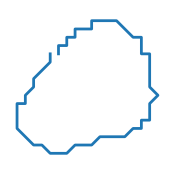

In [31]:
draw_stroke_sequence(temp_output_data[22])

# 0: [0, 3, 5, 10, 12, 16, 18, 20, 21, 22]
# 1: [100, 101, 102, 103, 104, 105, 107, 109, 110, 112]
# 2: [213, 218, 221, 230, 232, 234, 241, 249, 253, 254]
# 3; [314, 325, 327, 345, 347, 350, 354, 358, 365, 366]
# 4: [403, 405, 414, 415, 430, 434, 438, 439, 450, 464]
# 5: [500, 524, 527, 531, 532, 545, 549, 558, 565, 569]
# 6: [625, 627, 628, 643, 659, 661, 671, 676, 679 ,682]
# 7: [712, 714, 723, 727, 729, 730, 736, 782, 795, 799]
# 8: [820, 828, 839, 866, 870, 873, 874, 875, 877, 883]
# 9: [908, 911, 922, 950, 952, 954, 956, 958, 962, 999]

In [32]:
temp_input_data = []
temp_output_data = []

for i in range(10):
    temp_onehot = np.zeros(10)
    temp_onehot[i] = 1
    
    smallest_10 = sorted(datas[i], key=lambda x: len(x[1]))[:100]
    for k in smallest_10:
        temp_input_data.append(temp_onehot)
        temp_output_data.append(k)

In [33]:
input_data = []
output_data = []

indexes = [0, 3, 5, 10, 12, 16, 18, 20, 21, 22, 100, 101, 102, 103, 104, 105, 107, 109, 110, 112, 213, 218, 221, 230, 232, 234, 241, 249, 253, 254, 314, 325, 327, 345, 347, 350, 354, 358, 365, 366,
           403, 405, 414, 415, 430, 434, 438, 439, 450, 464, 500, 524, 527, 531, 532, 545, 549, 558, 565, 569, 625, 627, 628, 643, 659, 661, 671, 676, 679 ,682, 712, 714, 723, 727, 729, 730, 736, 782, 795, 799,
           820, 828, 839, 866, 870, 873, 874, 875, 877, 883, 908, 911, 922, 950, 952, 954, 956, 958, 962, 999]

input_data = [temp_input_data[i] for i in indexes]
output_data = [temp_output_data[i] for i in indexes]



Data Processing

In [34]:
# Finding the max length of a sequence
max_length = 0
j = 0
for i in range(len(output_data)):
    if len(output_data[i]) > max_length:
        max_length = len(output_data[i])
    j += 1

print(max_length)
print(j)

62
100


In [35]:
print(len(output_data))

100


In [37]:
# Padding the sequences so that they are all the same size (good for batching)
padded_output_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_output_data[i, :len(output_data[i]), :] = output_data[i]
    padded_output_data[i, len(output_data[i]):, :] = [0, 0, 0, 1]

In [38]:
padded_input_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_input_data[i, 0, :] = [0, 0, 0, 0]
    padded_input_data[i, 1:, :] = padded_output_data[i, :max_length-1, :]

In [39]:
class StrokeDataset(Dataset):
    def __init__(self, onehot, inputs, outputstroke):
        self.digit = onehot                     # shape: [N]
        self.inputstroke = inputs               # list of [seq_len, 4] arrays
        self.outputstroke = outputstroke        # list of [seq_len, 4] arrays

    def __len__(self):
        return len(self.digit)

    def __getitem__(self, idx):
        digit = self.digit[idx]
        inputs = self.inputstroke[idx]
        outputs = self.outputstroke[idx]
        return torch.tensor(digit, dtype=torch.float32), torch.tensor(inputs, dtype=torch.float32), torch.tensor(outputs, dtype=torch.float32)

In [40]:
strokeDataset = StrokeDataset(input_data, padded_input_data, padded_output_data)

In [41]:
loader = DataLoader(strokeDataset, batch_size=4, shuffle=True)

Creating Model

Notes


RNN:
input_size = output_size 


In [43]:
class DigitToStrokeLSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, batch_size=32):
        super(DigitToStrokeLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.embedding = nn.Linear(10, hidden_size)  # From one-hot to hidden dim
        
        # LSTM
        # Output layer: predicts [dx, dy, eos, eod]
        # Inital hidden state is the one-hot of number
        # Initial input is [0, 0, 0, 0, 0]
        # Input at t > 0 is output from t-1
        
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1
        )

        # Output layer: predicts [dx, dy, eos, eod]
        self.output_head = nn.Linear(hidden_size, 4)
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()  # For eos/eod
        self.tanh = nn.Tanh()


    def forward(self, x, hidden=None, onehot_digit=None):
        
        if onehot_digit != None and hidden == None:
            # Embed the digit
            h0 = self.embedding(onehot_digit)
            h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
            c0 = torch.zeros_like(h0)
            hidden = (h0, c0)

        elif hidden == None and onehot_digit == None:
            hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                      torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
            
        out, hidden = self.lstm(x, hidden)
        out = self.dropout(out)
        out = self.output_head(out)
        
        out[:, :, 0:2] = self.tanh(out[:, :, 0:2])
        # out[:, :, 2:] = self.sigmoid(out[:, :, 2:])
        
        return out, hidden
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# DAMAGE WEIGHTS

def damage_smallest(model, p_smallest): # energy constraint
    for name, param in model.named_parameters():
        if param.requires_grad and param.ndim >= 2:
            if p_smallest == 0:
                continue

            tensor = param.data
            weight_magnitudes = tensor.abs().view(-1)
            k = int(weight_magnitudes.numel() * p_smallest)

            if k == 0:
                continue
            threshold = weight_magnitudes.kthvalue(k).values.item()

            mask = tensor.abs() >= threshold
            param.data.mul_(mask)

def damage_fas(model,  p_block, p_reflect, p_filter):
    for name, param in model.named_parameters():
        if param.requires_grad and param.ndim >= 2:
            if p_block + p_reflect + p_filter == 0:
                continue

            tensor = param.data
            flat_weights = tensor.view(-1)
            nonzero_indices = (flat_weights!=0).nonzero(as_tuple=True)[0]
            num_nonzero_indices = nonzero_indices.numel()
            if num_nonzero_indices == 0:
                continue

            # percentage of weights damaged will be taken from the number of nonzero weights
            # simulated fas damage occurs after energy constraint blockage
            num_block = int(num_nonzero_indices * p_block)
            num_reflect = int(num_nonzero_indices * p_reflect)
            num_filter = int(num_nonzero_indices * p_filter)

            shuffled_indices = nonzero_indices[torch.randperm(num_nonzero_indices, device=flat_weights.device)]

            indices_block = shuffled_indices[:num_block]
            indices_reflect = shuffled_indices[num_block:num_block+num_reflect]
            indices_filter = shuffled_indices[num_block+num_reflect:num_block+num_reflect+num_filter]

            # do damage
            # blockage: set weights to 0
            if p_block != 0:
                flat_weights[indices_block] = 0

            # reflect: halve weights
            if p_reflect != 0:
                flat_weights[indices_reflect] *= 0.5

            # filter: low pass filter (lusch et al)
            if p_filter != 0:
                weights_to_filter = flat_weights[indices_filter]            # get weights before transformation
                signs = torch.sign(weights_to_filter)                       # get signs of weights
                abs_weights_to_filter = weights_to_filter.abs()             # get high_weight, should be in the 95th percentile for all weights
                high_weight = torch.quantile(flat_weights.abs(), 0.95)      # scale weights to mostly between -1 and 1
                x = abs_weights_to_filter / high_weight
                transformed_weights = -0.2744 * x**2 + 0.9094 * x - 0.0192
                gaussian_noise = torch.randn_like(transformed_weights) * 0.05
                transformed_weights += gaussian_noise
                transformed_weights = transformed_weights * signs * high_weight # rescale
                flat_weights[indices_filter] = transformed_weights


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitToStrokeLSTM().to(device)

# # damage weights to simulate energy constraint and lesioning
# damage_smallest(model, 0.0)
# damage_fas(model, 0.0, 0.0, 0.0)

dx_dy_loss_fn = nn.MSELoss()
eos_eod_loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for (dig, input_seq, output_seq) in loader:
        # stroke_seq: [batch, seq_len, 4]
        input_seq = input_seq.to(device)
        target_seq = output_seq.to(device)
        dig = dig.to(device)

        pred_seq, hidden = model(input_seq, onehot_digit = dig)  # [batch, seq_len-1, 4]

        # Separate predictions
        pred_dxdy = pred_seq[..., :2]         # [batch, seq_len-1, 2]
        pred_eos_eod = pred_seq[..., 2:]      # [batch, seq_len-1, 2]

        # Separate targets
        target_dxdy = target_seq[..., :2]
        target_eos_eod = target_seq[..., 2:]

        # Compute losses
        loss_dxdy = dx_dy_loss_fn(pred_dxdy, target_dxdy)
        loss_eos_eod = eos_eod_loss_fn(pred_eos_eod, target_eos_eod)

        loss = loss_dxdy + loss_eos_eod

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

Epoch 1 | Loss: 10.7967
Epoch 2 | Loss: 5.8020
Epoch 3 | Loss: 3.9187
Epoch 4 | Loss: 2.9592
Epoch 5 | Loss: 2.6414
Epoch 6 | Loss: 2.5206
Epoch 7 | Loss: 2.3014
Epoch 8 | Loss: 2.1733
Epoch 9 | Loss: 2.0526
Epoch 10 | Loss: 2.0793
Epoch 11 | Loss: 1.9865
Epoch 12 | Loss: 1.8658
Epoch 13 | Loss: 1.8362
Epoch 14 | Loss: 1.8057
Epoch 15 | Loss: 1.7884
Epoch 16 | Loss: 1.7921
Epoch 17 | Loss: 1.7545
Epoch 18 | Loss: 1.7719
Epoch 19 | Loss: 1.7742
Epoch 20 | Loss: 1.8082
Epoch 21 | Loss: 1.7528
Epoch 22 | Loss: 1.7542
Epoch 23 | Loss: 1.7374
Epoch 24 | Loss: 1.6930
Epoch 25 | Loss: 1.7350
Epoch 26 | Loss: 1.7194
Epoch 27 | Loss: 1.6913
Epoch 28 | Loss: 1.6560
Epoch 29 | Loss: 1.6603
Epoch 30 | Loss: 1.6906
Epoch 31 | Loss: 1.6625
Epoch 32 | Loss: 1.6420
Epoch 33 | Loss: 1.6256
Epoch 34 | Loss: 1.6889
Epoch 35 | Loss: 1.6835
Epoch 36 | Loss: 1.6425
Epoch 37 | Loss: 1.6294
Epoch 38 | Loss: 1.6111
Epoch 39 | Loss: 1.6487
Epoch 40 | Loss: 1.6299
Epoch 41 | Loss: 1.6370
Epoch 42 | Loss: 1.6555


In [52]:
def generate_text(number):
    model.eval()
    
    temp_onehot = np.zeros(10)
    temp_onehot[number] = 1
    temp_onehot = torch.tensor(temp_onehot, dtype=torch.float32).to(device)
    
    initial_input = torch.tensor([0, 0, 0, 0], dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(1)
    
    outputs = []
    
    output, hidden = model(initial_input, onehot_digit=temp_onehot)
    output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()

    outputs.append(output[:, -1, :].detach().cpu().numpy()[0])

    for i in range(max_length-1):
        output, hidden = model(output, hidden=hidden)
        output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()
        outputs.append(output[:, -1, :].detach().cpu().numpy()[0])
        
        # print(outputs[-1])
        if output[:, -1, 3] == 1:
            # print("HI")
            break
    
    draw_stroke_sequence(outputs)


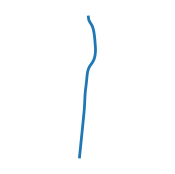

In [55]:
generate_text(1)

In [7]:
# Save model if good
torch.save(model.state_dict(), 'model_weights.pth')

NameError: name 'model' is not defined

In [9]:
model = DigitToStrokeLSTM().to(device) # create a new instance
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()  # set to evaluation mode if you're doing inference

DigitToStrokeLSTM(
  (embedding): Linear(in_features=10, out_features=256, bias=True)
  (lstm): LSTM(4, 256, num_layers=2, batch_first=True)
  (output_head): Linear(in_features=256, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)

In [12]:
generate_text(0)

NameError: name 'max_length' is not defined

In [ ]:
# shit: 0, 5, 6, 8, 9